# Example Analysis with OptLevAnalysis

### Imports
Import required packages along with `AggregateData` and `FileData` from `../lib/data_processing.py`

In [1]:
import sys
import numpy as np
import matplotlib.pyplot as plt
sys.path.insert(0,'../lib/')
from data_processing import AggregateData, FileData

### Load a single file
We can use the `FileData` class directly to load and process data from a single file. Start by creating the `FileData` object, then run the `load_data()` method to populate the object attributes with the raw data.

This method calls the following:
* `read_hdf5()` to create a dictionary of the raw data
* `get_xyz_from_quad()` to calculate the x, y, and z data from the QPD data, which in turn calls
    * `extract_quad()` to parse the raw QPD data into sensible arrays
* `calibrate_stage_position()` to get the cantilever positions in microns
* `calibrate_bead_response()` to apply the transfer function. This calls one of the following:
    * `tf_array_fitted()` to get the transfer function based on fitting the poles/zeros, used for all data from 2023 and later
    * `tf_array_interpolated()` to interpolate the transfer function at the desired frequencies. Only included to reprocess Wilson data with the old transfer function format.
* `get_boolean_cant_filter()` to create a filter of a specified width for selecting only the harmonics used later in the analysis
* `get_ffts_and_noise()` to get the FFTs for the cantilever and the bead, along with the noise from the sidebands

More information on how to use each method can be found in the comments in the data processing script. After loading the data, the object should have the attributes listed after the next cell.

In [2]:
filedat = FileData('/data/new_trap/20230614/Bead0/Gravity/4/shaking_1.h5')
filedat.load_data()
# print out the class attributes
for d in dir(filedat):
    if d[:2]!='__':
        print(d)

amps
bead_ffts
bead_ffts_full
bead_force_calibrated
build_drive_mask
calibrate_bead_response
calibrate_stage_position
cant_pos_calibrated
cant_raw_data
data_dict
date
drive_fft
drive_ind
extract_quad
file_name
force_cal_factors
freqs
fsamp
get_boolean_cant_mask
get_diag_mat
get_ffts_and_noise
get_xyz_from_quad
good_inds
is_bad
load_data
mean_cant_pos
nsamp
phases
qpd_diag_mat
quad_amps
quad_phases
quad_raw_data
read_hdf5
seismometer
sideband_ffts
tf_array_fitted
tf_array_interpolated
times


### Handling multiple files or datasets
The `FileData` class is intended to be called by the `AggregateData` class when loading multiple files at once. To initialize an `AggregateData` object, call `AggregateData()` with the following arguments:
* `data_dirs`, a list of the full paths to the directories containing the raw hdf5 files to be processed
* `file_prefixes`, a list of prefixes used to select specific files from within the directory. If you want all files from a directory, omit this argument. If you want multiple prefixes from the same directory, repeat the directory path in the `data_dirs` argument and add the corresponding file prefixes.
* `descrips`, a list of descriptions intended to be useful to the user in identifying different dataset
* `num_to_load` a list of the number of files to load from each directory, or an integer to load the same number from all directories. If this argument is omitted, all files from each directory will be included.

In the example below, an `AggregateData` object for 100 files from the Wilson data and a dataset from June 14, 2023 is initialized.


In [3]:
aggdat = AggregateData(['/data/new_trap/20230614/Bead0/Gravity/4/','/data/new_trap/20200320/Bead1/Shaking/Shaking378/'],\
                       file_prefixes=['shaking_','Shaking1'],descrips=['June 2023','Wilson'],num_to_load=[100,100])

### Loading the data
To load and preprocess the data, call the `load_file_data()` method with the following arguments:
* `num_cores`, the number of cores to use for processing the files in parallel
* `lightweight`, a boolean parameter which determines whether or not to keep the raw data as a class attribute. If set to False, only the reduced data will be accessible within the `AggregateData` object.

This method also takes care of a few additional organizational steps:
* Saves the full list of files imported as a class attribute
* Loads the bead positions `p0_bead` and diameters `diam_bead` from a config file, `config.yaml`, located in the same directory as the hdf5 files. Removes any duplicate entries for easier indexing (described in more detail further down).
* Identifies any bad files, saves a list of the filenames, and purges them from the `AggregateData` object

At this point a list of the `FileData` objects has been loaded, so all the `FileData` attributes can be accessed, albeit in a clunky way. To make accessing these parameters for many datasets at a time easier, a private methoc called `__build_dict()` will extract all the data from the `FileData` objects and put it into the `agg_dict` attribute of the `AggregateData` class.

In [4]:
aggdat.load_file_data(num_cores=20,lightweight=False)
aggdat.agg_dict.keys()

  0%|          | 0/200 [00:00<?, ?it/s]

 60%|██████    | 120/200 [00:02<00:01, 42.13it/s]/home/clarkeh/OptLevAnalysis/notebooks/../lib/funcs.py:78: RuntimeWarning: divide by zero encountered in log10
  return popt_l[0] * np.log10(x) + c
/home/clarkeh/OptLevAnalysis/notebooks/../lib/data_processing.py:344: RuntimeWarning: invalid value encountered in multiply
  Harr[:,drive,resp] = mag * np.exp(1.0j * phase)
/home/clarkeh/OptLevAnalysis/notebooks/../lib/data_processing.py:344: RuntimeWarning: invalid value encountered in exp
  Harr[:,drive,resp] = mag * np.exp(1.0j * phase)
/home/clarkeh/OptLevAnalysis/notebooks/../lib/funcs.py:78: RuntimeWarning: divide by zero encountered in log10
  return popt_l[0] * np.log10(x) + c
/home/clarkeh/OptLevAnalysis/notebooks/../lib/data_processing.py:344: RuntimeWarning: invalid value encountered in multiply
  Harr[:,drive,resp] = mag * np.exp(1.0j * phase)
/home/clarkeh/OptLevAnalysis/notebooks/../lib/data_processing.py:344: RuntimeWarning: invalid value encountered in exp
  Harr[:,drive,resp

Successfully loaded 200 files.
Building dictionary of file data...
Done building dictionary.


dict_keys(['dates', 'times', 'seismometer', 'cant_raw_data', 'quad_raw_data', 'mean_cant_pos', 'freqs', 'good_inds', 'bead_ffts', 'bead_ffts_full', 'sideband_ffts', 'drive_fft', 'quad_amps', 'quad_phases'])

### Binning by auxiliary data
Ultimately we may want to load many datasets but look only at a subset of that data that meets some criteria for a particular analysis. Rather than creating multiple sparse, nested arrays, data for all files loaded is kept in a single 1-D array, and a secondary array is used to track the indices. For each file loaded, there is a corresponding row in the array of indices that includes the following information:
* `diam_bead` index: The index that can be used to select the correct bead diameter value from the array containing all values for the `AggregateData` object.
* `p0_bead` index: Same thing, but for the bead position.
* `descrips` index: Same thing, but for the descriptions passed in for each directory when the constructor was called.
* `cant_bins_x` index: An index that determines which bin of mean cantilever x positions the file falls into.
* `cant_bins_z` index: Same thing, but for the mean cantilever z positions.
* `seis_thresh` index: 0 if the file passes the seismometer threshold cut, 1 if it doesn't.
* `bias` index: Not yet implemented, but will eventualy index the attractor/shield bias.
* `is_bad` index: 1 if the file is bad, 0 otherwise. This is used for purging, so in principle after the data is loaded all values should be 0.

The method `bin_by_aux_data()` takes the following arguments:
* `cant_bin_widths`: a list containing the bin widths for the cantilever x and z positions. The data will be histogrammed into bins of the specified widths, then empty bins will be removed and the indices adjusted accordingly.
* `seis_thresh`: the threshold value used in the seismometer data cut.

Once this method has been called, the `bin_indices` attribute should be fully populated and can be used for indexing arbitrary slices of data.

In [5]:
aggdat.bin_by_aux_data(cant_bin_widths=[1.,1.],seis_thresh=0.01)
print(aggdat.bin_indices[:5])
print(aggdat.bin_indices[-5:])

Binning data by mean cantilever position and seismometer data...
Done binning data.
[[0 0 0 0 0 1 0 0]
 [0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0]
 [0 0 0 0 0 1 0 0]
 [0 0 0 0 0 1 0 0]]
[[1 1 1 1 0 0 0 0]
 [1 1 1 1 0 0 0 0]
 [1 1 1 1 0 0 0 0]
 [1 1 1 1 0 0 0 0]
 [1 1 1 1 0 0 0 0]]


### Getting arbitrary slices of data
The `bin_indices` attribute will be mostly used for selecting the correct signal model to use for each file when computing sensitivity limits, but on its own it's not particularly user-friendly for slicing up the data. To select subsets of data that meet certain conditions, the `get_slice_indices()` method should be used instead. This method takes the following arguments:
* `diam_bead`: a float or a list of floats containing the desired bead diameters in microns.
* `descrips`: a string or list of strings containing the descriptions of the datasets chosen when the constructor was called.
* `cant_x`: a range of mean cantilever x positions in microns to include, of the form `[lower,upper]`.
* `cant_z`: same as above for the mean cantilever z positions.
* `seis_veto`: a boolean that says whether or not data not passing the seismometer cut should be included.

This method returns an array of the indices of files that pass the cuts. As an example, in the cell below we create separate index arrays for the Wilson data and the June 2023 data and require that all files from both pass the siesmometer cut. This array of indices is then used to compare the QPD x and y spectra.

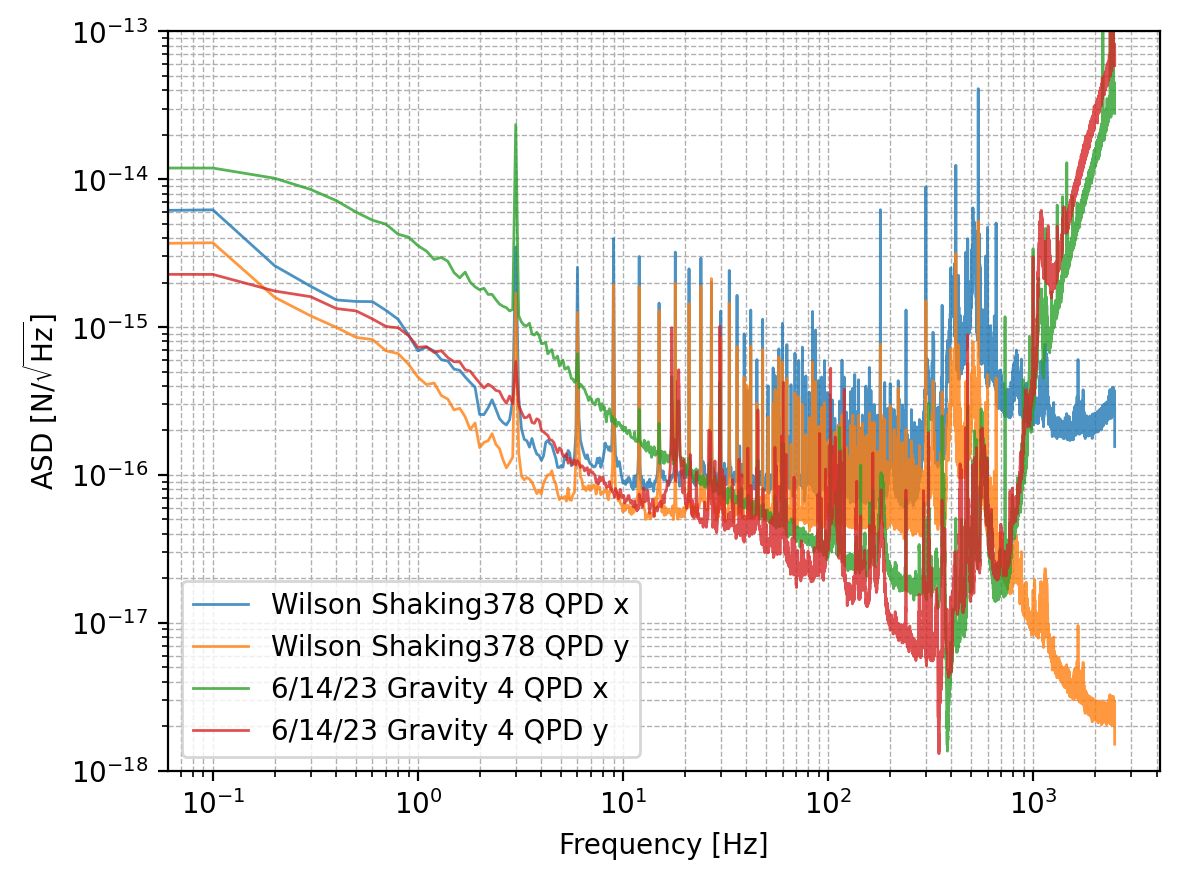

In [6]:
# get arrays of indices
indices_wilson = aggdat.get_slice_indices(descrip='Wilson')
indices_2023 = aggdat.get_slice_indices(descrip='June 2023')

# use the indices to select the FFTs in x and y for each from the AggregateData dictionary
# first index is the file, second is x/y/z, third is the frequency
ffts_x_wilson = aggdat.agg_dict['bead_ffts_full'][indices_wilson][:,0,:]
ffts_y_wilson = aggdat.agg_dict['bead_ffts_full'][indices_wilson][:,1,:]
ffts_x_2023 = aggdat.agg_dict['bead_ffts_full'][indices_2023][:,0,:]
ffts_y_2023 = aggdat.agg_dict['bead_ffts_full'][indices_2023][:,1,:]

# get the frequency array
freqs = aggdat.agg_dict['freqs'][0]

# we'll just plot the average over the datasets included
mean_ffts_x_wilson = np.mean(np.abs(ffts_x_wilson),axis=0)
mean_ffts_y_wilson = np.mean(np.abs(ffts_y_wilson),axis=0)
mean_ffts_x_2023 = np.mean(np.abs(ffts_x_2023),axis=0)
mean_ffts_y_2023 = np.mean(np.abs(ffts_y_2023),axis=0)

# now make the plot
plt.figure(dpi=200)
plt.loglog(freqs,mean_ffts_x_wilson,lw=1.,alpha=0.8,label='Wilson Shaking378 QPD x')
plt.loglog(freqs,mean_ffts_y_wilson,lw=1.,alpha=0.8,label='Wilson Shaking378 QPD y')
plt.loglog(freqs,mean_ffts_x_2023,lw=1.,alpha=0.8,label='6/14/23 Gravity 4 QPD x')
plt.loglog(freqs,mean_ffts_y_2023,lw=1.,alpha=0.8,label='6/14/23 Gravity 4 QPD y')
plt.xlabel('Frequency [Hz]')
plt.ylabel('ASD [N/$\sqrt{\mathrm{Hz}}$]')
plt.grid(which='both',ls='--',lw=.5)
plt.ylim([1e-18,1e-13])
plt.legend(loc='best')

### Miscellaneous file handling methods
`AggregateData` objects can be saved and loaded using the `save()` and `load()` methods respectively. The only argument to both is the path to where the object should be/was saved.

Any number of `AggregateData` objects can be merged into one after the fact using the `merge_objects()` method with a list of objects as the argument, so that if more datasets need to be added the existing data does not need to be reprocessed. This should be called by constructing a new `AggregateData` object first and then calling the method to fill it with the existing objects.

For now, the `bin_indices` attribute is limited and does not accomodate every possible way in which the data might be sliced up. If, for example, you wanted to compare data with the diagonalized QPD response to data with the naive position calculation, this could be done by loading each dataset into separate objects with different `descrips` arguments. Next, the data could be loaded with the `diagonalize_qpd` argument set to true for one object and false for the other. Finally, the two objects could be merged into a single object, allowing each subset of data to be selected with the `descrips` attribute.